### Import Libraries

In [1]:
import os
print(os.getcwd())

# PyTorch
import torch 
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, fasterrcnn_resnet50_fpn
import albumentations as A

# Image processing
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont

# Image Plots
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Data managements
import numpy as np
import pandas as pd

# File interpretation
import os
import xml.etree.ElementTree as ET
import random

# Others
import time
from collections import Counter
from random import seed, randint
from datetime import datetime

/home/srjung/demo_ML/factory


In [2]:
# 만약에 라이브러리가 없다면 아래 코드 주석 제거하고 실행시키기
# !pip install torch
# !pip install torchvision
# !pip install albumentations

### 이미지 라벨링 처리

![라벨링데이터 이미지](https://user-images.githubusercontent.com/69622147/177708249-c4d94b0a-66e5-4e85-9d50-a5475fbda924.png)

### 라벨링 파일 불러오기

Indicate the path for the annotation files.

In [26]:
##############################################
# 라벨링 완료된 파일 디렉토리 설정
ann_directory = './factory_data/annotations'
##############################################

# List directory
ann_files = os.listdir(ann_directory)

### 이미지 파일 불러오기

Indicate the path for the image files.

In [5]:
##############################################
# 학습 대상 파일 디렉토리 설정
img_directory = './factory_data/images'
##############################################

# List directory
img_files = os.listdir(img_directory)

### 함수 정의

#### - 이미지에 얼굴 인식 바운딩 박스 그리는 함수

In [6]:
def draw_bounding_boxes(img_tensor, target=None, prediction=None):
    """Draws bounding boxes in given images. Displays them

        Inputs:
          img:
            Image in tensor format.
          target:
            target dictionary containing bboxes list wit format -> [xmin, ymin, xmax, ymax]

        Returns:
          None
        """

    img = torchvision.transforms.ToPILImage()(img_tensor)

    # fetching the dimensions
    wid, hgt = img.size
    print(str(wid) + "x" + str(hgt))

    # Img to draw in
    draw = ImageDraw.Draw(img)

    if target:
        target_bboxes = target['boxes'].numpy().tolist()
        target_labels = decode_labels(target['labels'].numpy())

        for i in range(len(target_bboxes)):
            # Create Rectangle patches and add the patches to the axes
            draw.rectangle(target_bboxes[i], fill=None, outline='green', width=2)
            draw.text(target_bboxes[i][:2], target_labels[i], fill='green', font=None, anchor=None, spacing=4,
                      align='left', direction=None, features=None, language=None, stroke_width=0, stroke_fill=None,
                      embedded_color=False)

    if prediction:
        prediction_bboxes = prediction['boxes'].detach().cpu().numpy().tolist()
        prediction_labels = decode_labels(prediction['labels'].detach().cpu().numpy())
        for i in range(len(prediction_bboxes)):
            # Create Rectangle patches and add the patches to the axes
            draw.rectangle(prediction_bboxes[i], fill=None, outline='red', width=2)
            draw.text(prediction_bboxes[i][:2], prediction_labels[i], fill='red', font=None, anchor=None, spacing=4,
                      align='left', direction=None, features=None, language=None, stroke_width=0, stroke_fill=None,
                      embedded_color=False)

    display(img)


#### - 라벨링 클래스 인덱싱 함수

0. 배경
1. 헬멧 착용한 사람
2. 헬멧 미착용한 사람

In [7]:
def encoded_labels(lst_labels):
    """Encodes label classes from string to integers.

        Labels are encoded accordingly:
            - background => 0
            - with_helmet => 1
            - without_helmet => 2
    """

    encoded=[]
    for label in lst_labels:
        if label == "with_helmet":
            code = 1
        elif label == "without_helmet":
            code = 2
        else:
            code = 0
        encoded.append(code)
    return encoded

In [8]:
def decode_labels(lst_labels):
    """
    Decode label classes from integers to strings.
    Labels are encoded accordingly:
        - background => 0
        - with_helmet => 1
        - without_helmet => 2
    """

    labels=[]
    for code in lst_labels:
        if code == 1:
            label = "with_helmet"
        elif code == 2:
            label = "without_helmet"
        else:
            label = 'background'
        labels.append(label)
    return labels

#### - 모델 생성 함수( Faster R-CNN)
-> 새로운 데이터 셋에 대한 전송 학습(Transfer learning)을 수행하기 위해 COCO train2017에 대해 미리 학습된 Mask R-CNN 모델을 활용

In [9]:
def build_model(nclasses):
    """
    Builds model. Uses Faster R-CNN pre-trained on COCO dataset.

    Args:
      nclasses:
        number of classes

    Return:
      model: Faster R-CNN pre-trained model
    """
    # load pre-trained model on COCO
    model = fasterrcnn_resnet50_fpn(pretrained=True, min_size=400, max_size=700)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, nclasses)

    return model

#### - 모델 학습 함수

In [10]:
def train_model(model, loader, optimizer, scheduler, epochs, device):
    """ 
    Inputs:
      - model
      - loader: Dataloader PyTorch object with training data
      - optimizer
      - scheduler
      - epochs
      - device

    Returns:
      - model
      - loss_list: list with mean loss per epoch. Epoch 1 is in idex 0.
    """
    # Create a loss list to keep epoch average loss
    loss_list = []
    # Epochs
    for epoch in range(epochs):
        print('Starting epoch...... {}/{} '.format(epoch + 1, epochs))
        iteration = 0
        loss_sub_list = []
        start = time.time()
        for images, targets in loader:
            # Agregate images in batch loader
            images = list(image.to(device) for image in images)

            # Agregate targets in batch loader
            targets = [{key: val.to(device) for key, val in target.items()} for target in targets]

            # Sets model to train mode (just a flag)
            model.train()

            # Output of model returns loss and detections
            optimizer.zero_grad()
            output = model(images, targets)

            # Calculate Cost
            losses = sum(loss for loss in output.values())
            loss_value = losses.item()
            loss_sub_list.append(loss_value)
            print('')

            # Update optimizer and learning rate
            losses.backward()
            optimizer.step()
            iteration += 1
            print('Iteration: {:d} --> Loss: {:.3f}'.format(iteration, loss_value))
          
        end = time.time()
        # update scheduler
        scheduler.step()
        # print the loss of epoch
        epoch_loss = np.mean(loss_sub_list)
        loss_list.append(epoch_loss)
        print('Epoch loss: {:.3f} , time used: ({:.1f}s)'.format(epoch_loss, end - start))
      
    return model, loss_list

In [11]:
def apply_nms(orig_prediction, iou_thresh):
    """
    Applies non max supression and eliminates low score bounding boxes.

      Args:
        orig_prediction: the model output. A dictionary containing element scores and boxes.
        iou_thresh: Intersection over Union threshold. Every bbox prediction with an IoU greater than this value
                      gets deleted in NMS.

      Returns:
        final_prediction: Resulting prediction
    """

    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    # Keep indices from nms
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

In [12]:
def remove_low_score_bb(orig_prediction, score_thresh):
    """
    Eliminates low score bounding boxes.

    Args:
        orig_prediction: the model output. A dictionary containing element scores and boxes.
        score_thresh: Boxes with a lower confidence score than this value get deleted

    Returns:
        final_prediction: Resulting prediction
    """

    # Remove low confidence scores according to given threshold
    index_list_scores = []
    scores = orig_prediction['scores'].detach().cpu().numpy()
    for i in range(len(scores)):
        if scores[i] > score_thresh:
            index_list_scores.append(i)
    keep = torch.tensor(index_list_scores)

    # Keep indices from high score bb
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

In [13]:
def collate_fn(batch):
    # Collate function for Dataloader
    return tuple(zip(*batch))

In [14]:
def IOU(box1, box2):
    '''
    Intersection over Union - IoU
    *------------
    |   (x2min,y2min)
    |   *----------
    |   | ######| |
    ----|------* (x1max,y1max)
        |         |
        ----------

    Args:
        box1: [xmin,ymin,xmax,ymax]
        box2: [xmin,ymin,xmax,ymax]

    Returns:
        iou -> value of intersection over union of the 2 boxes

    '''

    # Compute coordinates of intersection
    xmin_inter = max(box1[0], box2[0])
    ymin_inter = max(box1[1], box2[1])
    xmax_inter = min(box1[2], box2[2])
    ymax_inter = min(box1[3], box2[3])

    # calculate area of intersection rectangle
    inter_area = max(0, xmax_inter - xmin_inter + 1) * max(0, ymax_inter - ymin_inter + 1) # FIXME why plus one?
 
    # calculate boxes areas
    area1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
 
    # compute IoU
    iou = inter_area / float(area1 + area2 - inter_area)
    assert iou >= 0
    return iou


In [15]:
def compute_AP(ground_truth, predictions, iou_thresh=0.5, n_classes=4):
    """
    Calculates Average Precision across all classes.

    Args:
        ground_truth: list with ground-truth objects. Needs to have the following format: [sequence, frame, obj, [xmin, ymin, xmax, ymax], label, score]
        predictions: list with predictions objects. Needs to have the following format: [sequence, frame, obj, [xmin, ymin, xmax, ymax], label, score]
        iou_thresh: IoU to which a prediction compared to a ground-truth is considered right.
        n_classes: number of existent classes

    Returns:
        Average precision for the specified threshold.
    """
    # Initialize lists
    APs = []
    class_gt = []
    class_predictions = []

    # AP is computed for each class
    for c in range(n_classes):
        # Find gt and predictions of the class
        for gt in ground_truth:
            if gt[4] == c:
                class_gt.append(gt)
        for predict in predictions:
            if predict[4] == c:
                class_predictions.append(predict)

        # Create dict with array of zeros for bb in each image
        gt_amount_bb = Counter([gt[1] for gt in class_gt])
        for key, val in gt_amount_bb.items():
            gt_amount_bb[key] = np.zeros(val)

        # Sort class predictions by their score
        class_predictions = sorted(class_predictions, key=lambda x: x[5], reverse=True)

        # Create arrays for Positives (True and False)
        TP = np.zeros(len(class_predictions))
        FP = np.zeros(len(class_predictions))
        # Number of true boxes
        truth = len(class_gt)

        # Initializing aux variables
        epsilon = 1e-6

        # Iterate over predictions in each image and compare with ground truth
        for predict_idx, prediction in enumerate(class_predictions):
            # Filter prediction image ground truths
            image_gt = [obj for obj in class_gt if obj[1] == prediction[1]]

            # Initializing aux variables
            best_iou = -1
            best_gt_iou_idx = -1

            # Iterate through image ground truths and calculate IoUs
            for gt_idx, gt in enumerate(image_gt):
                iou = IOU(prediction[3], gt[3])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_iou_idx = gt_idx

            # If the best IoU is greater that thresh than an TP prediction has been found
            if best_iou > iou_thresh and best_gt_iou_idx > -1:
                # Check if gt box was already covered
                if  gt_amount_bb[prediction[1]][best_gt_iou_idx] == 0:
                    gt_amount_bb[prediction[1]][best_gt_iou_idx] = 1  # set as covered
                    TP[predict_idx] = 1  # Count as true positive
                else:
                    FP[predict_idx] = 1
            else:
                FP[predict_idx] = 1

        # Calculate recall and precision
        TP_cumsum = np.cumsum(TP)
        FP_cumsum = np.cumsum(FP)
        recall = np.append([0], TP_cumsum / (truth + epsilon))
        precision = np.append([1], np.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon)))

        # Calculate the area precision/recall and add to list
        APs.append(np.trapz(precision, recall))

    return sum(APs)/len(APs)  # average of class precisions


def compute_mAP(ground_truth, predictions, n_classes):
    """
    Calls AP computation for different levels of IoUs, [0.5:.05:0.95].

    Args:
        ground_truth: list with ground-truth objects. Needs to have the following format: [sequence, frame, obj, [xmin, ymin, xmax, ymax], label, score]
        predictions: list with predictions objects. Needs to have the following format: [sequence, frame, obj, [xmin, ymin, xmax, ymax], label, score]
        n_classes: number of existent classes.

    Returns:
        mAp and list with APs for each IoU threshold.
    """
    # return mAP
    APs = [compute_AP(ground_truth, predictions, iou_thresh, n_classes) for iou_thresh in np.arange(0.5, 1.0, 0.05)]
    return np.mean(APs), APs

In [16]:
@torch.no_grad()
def evaluate(model, data_loader, device, sequences=1):
    """
    Evaluates model mAP for IoU range of [0.5:.05:0.95].

    Args:
        model: -
        data_loader: -
        device: -
        sequences: the number of sequences of images to pass, if any

    Returns:
        mAP and AP list for each IoU threshold in range [0.5:.05:0.95]
    """

    # Set evaluation mode flag
    model.eval()
    # Create list with all object detection -> [set, frame, obj, [xmin,ymin,xmax,ymax], label, score]
    ground_truth = []
    predictions = []

    # Gather all targets and outputs on test set
    for image, targets in data_loader:
        image = [img.to(device) for img in image]
        outputs = model(image)
        for idx in range(len(outputs)):
            outputs[idx] = apply_nms(outputs[idx], iou_thresh=0.5)

        # create list for targets and outputs to pass to compute_mAP()
        # lists have the following structure:  [sequence, frame, obj_idx, [xmin, ymin, xmax, ymax], label, score]
        for s in range(sequences):
            obj_gt = 0
            obj_target = 0
            for out, target in zip(outputs, targets):

                for i in range(len(target['boxes'])):
                    ground_truth.append([s, target['image_id'].detach().cpu().numpy()[0], obj_target,
                                         target['boxes'].detach().cpu().numpy()[i],
                                         target['labels'].detach().cpu().numpy()[i], 1])
                    obj_target += 1

                for j in range(len(out['boxes'])):
                    predictions.append([s, target['image_id'].detach().cpu().numpy()[0], obj_gt,
                                        out['boxes'].detach().cpu().numpy()[j],
                                        out['labels'].detach().cpu().numpy()[j],
                                        out['scores'].detach().cpu().numpy()[j]])
                    obj_gt += 1

    mAP, AP = compute_mAP(ground_truth, predictions, n_classes=4)
    print("mAP:{:.3f}".format(mAP))
    for ap_metric, iou in zip(AP, np.arange(0.5, 1, 0.05)):
        print("\tAP at IoU level [{:.2f}]: {:.3f}".format(iou, ap_metric))

    return mAP, AP

### 데이터셋별 클래스 생성
Dataset class to feed the dataloader.

#### 1. training dataset

In [27]:
# Create dataset object
class MyDataset(Dataset):

    # Constructor
    def __init__(self, ann_dir, img_dir, transform=None, mode='train'):  # ann_directory,img_directory, mode = 'train'

        # Image directories
        self.ann_dir = ann_dir
        self.img_dir = img_dir

        # The transform is goint to be used on image
        self.transform = transform

        # Create dataframe to hold info
        self.data = pd.DataFrame(columns=['Filename', 'BoundingBoxes', 'Labels', 'Area', 'N_Objects'])

        # Append rows with image filename and respective bounding boxes to the df
        for file in enumerate(os.listdir(img_dir)):

            # Find image annotation file
            ann_file_path = os.path.join(ann_dir, file[1][:-4]) + '.xml' 

            # Read XML file and return bounding boxes and class attributes
            objects = self.read_XML_classf(ann_file_path)  # XML 파일의 object들

            # Create list of labels in an image
            list_labels = encoded_labels(objects[0]['labels']) # 라벨링 파일의 바운딩 박스할 데이터 리스트 생성

            # 버윤당 박스 영역 리스트로 저장
            list_bb = []
            list_area = []
            n_obj = len(objects[0]['objects'])
            for i in objects[0]['objects']:
                list = [i['xmin'], i['ymin'], i['xmax'], i['ymax']]
                list_bb.append(list)
                list_area.append((i['xmax'] - i['xmin']) * (i['ymax'] - i['ymin']))

            # Create dataframe object with row containing [(Image file name),(Bounding Box List)]
            df = pd.DataFrame([[file[1], list_bb, list_labels, list_area, n_obj]],
                              columns=['Filename', 'BoundingBoxes', 'Labels', 'Area', 'N_Objects'])
            self.data = self.data.append(df)

        if mode == 'train':
            self.data = self.data[:40]   # 80%
        elif mode == 'validation':
            self.data = self.data[40:42]  # 
        elif mode == 'test':
            self.data = self.data[42:50]  # 

        # Number of images in dataset
        self.len = self.data.shape[0]

        # Get the length

    def __len__(self):
        return self.len

    # Getter
    def __getitem__(self, idx):

        # Image file path
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])

        # Open image file and tranform to tensor
        img = Image.open(img_name).convert('RGB')

        # Get bounding box coordinates
        bbox = torch.tensor(self.data.iloc[idx, 1])

        # Get labels
        labels = torch.tensor(self.data.iloc[idx, 2])

        # Get bounding box areas
        area = torch.tensor(self.data.iloc[idx, 3])

        # If any, aplly tranformations to image and bounding box mask
        if self.transform:
            # Convert PIL image to numpy array
            img = np.array(img)
            # Apply transformations
            transformed = self.transform(image=img, bboxes=bbox)
            # Convert numpy array to PIL Image
            img = Image.fromarray(transformed['image'])
            # Get transformed bb
            bbox = torch.tensor(transformed['bboxes'])

        # suppose all instances are not crowd
        num_objs = self.data.iloc[idx, 4]
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Transform img to tensor
        img = torchvision.transforms.ToTensor()(img)

        # Build Targer dict
        target= {"boxes": bbox, "labels": labels, "image_id": torch.tensor([idx]), "area": area, "iscrowd": iscrowd}

        return img, target

    # XML reader -> returns dictionary with image bounding boxes sizes
    def read_XML_classf(self, ann_file_path):
        bboxes = [{
            'file': ann_file_path,
            'labels': [],
            'objects': []
        }]

        # Reading XML file objects and print Bounding Boxes
        tree = ET.parse(ann_file_path)
        root = tree.getroot()
        objects = root.findall('object')

        for obj in objects:
            # label
            label = obj.find('name').text
            bboxes[0]['labels'].append(label)

            # bbox dimensions
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            bboxes[0]['objects'].append({'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax})

        return bboxes




### 데이터셋 분리(training, test, validation)

In [28]:
import warnings

warnings.filterwarnings(action='ignore') 

# Create Data Pipeline

# Training Data
dataset_train = MyDataset(ann_directory,img_directory, mode = 'train')
loader_train = DataLoader(dataset_train, batch_size=4, shuffle=True, collate_fn=collate_fn)
# Validation Data
dataset_validation = MyDataset(ann_directory,img_directory, mode = 'validation')
loader_val = DataLoader(dataset_validation, batch_size=4, shuffle=True, collate_fn=collate_fn)
# Test Data
dataset_test = MyDataset(ann_directory,img_directory, mode = 'test')
loader_test = DataLoader(dataset_test, batch_size=4, shuffle=True, collate_fn=collate_fn)

Test if dataset is working correctly. Print out ground truth bounding box of first image.

1024x695


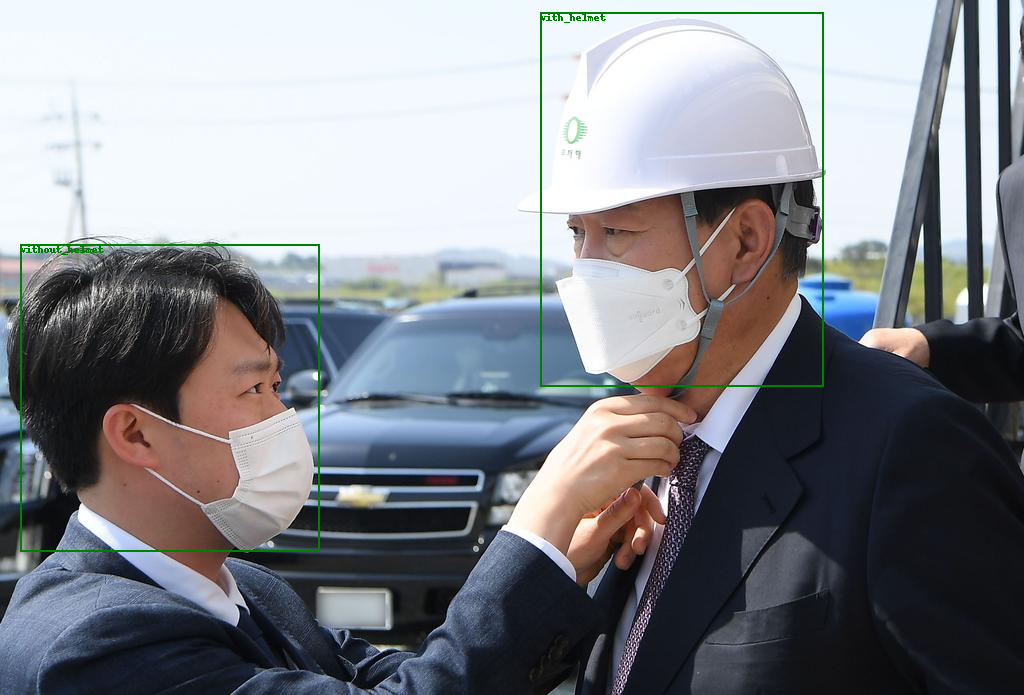

In [29]:
# pick one image from the train set
img, target = dataset_train[0]
draw_bounding_boxes(img, target)

### Faster R-CNN Model 셋팅하기

In [30]:
# Setting up GPU device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Nº of classes: background, with_mask, mask_weared_incorrect, without_mask and build model (faster r-cnn)
num_classes = 4 
model = build_model(num_classes)

model = model.to(device)

In [31]:
# Set Hyper-parameters

# Network params
params = [p for p in model.parameters() if p.requires_grad]

# Optimizers
optimizer = torch.optim.Adam(params, lr=0.0001)
#optimizer = torch.optim.SGD(params, lr=0.005)

# Learning Rate, lr decreases to half every 2 epochs 
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# Number of epochs to perform
epochs=1


### 모델 학습

In [22]:
# pip install Cython
# pip install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"

In [23]:
pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/gautamchitnis/cocoapi.git (to revision cocodataset-master) to /tmp/pip-req-build-725rk7fh
  Running command git clone --filter=blob:none --quiet https://github.com/gautamchitnis/cocoapi.git /tmp/pip-req-build-725rk7fh
  Running command git checkout -b cocodataset-master --track origin/cocodataset-master
  새로 만든 'cocodataset-master' 브랜치로 전환합니다
  'cocodataset-master' 브랜치가 리모트의 'cocodataset-master' 브랜치를 ('origin'에서) 따라가도록 설정되었습니다.
  Resolved https://github.com/gautamchitnis/cocoapi.git to commit 20291f19c46a8d11935862bc9e449a1b72ec25ed
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [24]:
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0

!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../
%cd ..

'vision'에 복제합니다...
remote: Enumerating objects: 169727, done.
remote: Counting objects: 100% (2097/2097), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 169727 (delta 1961), reused 2069 (delta 1951), pack-reused 167630
오브젝트를 받는 중: 100% (169727/169727), 333.85 MiB | 11.75 MiB/s, 완료.
델타를 알아내는 중: 100% (151575/151575), 완료.
/home/srjung/demo_ML/factory/vision
Note: switching to 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD의 현재 위치는 be376084d version check against PyTorch's CUDA version
/home

In [32]:
from engine import train_one_epoch
# Training
for epoch in range(epochs):
    # train for one epoch, printing every 50 iterations
    train_one_epoch(model, optimizer, loader_train, device, epoch, print_freq=20)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, loader_val, device=device)

Epoch: [0]  [ 0/10]  eta: 0:01:18  lr: 0.000011  loss: 1.8990 (1.8990)  loss_classifier: 1.6102 (1.6102)  loss_box_reg: 0.1680 (0.1680)  loss_objectness: 0.1130 (0.1130)  loss_rpn_box_reg: 0.0078 (0.0078)  time: 7.8472  data: 0.0155  max mem: 0
Epoch: [0]  [ 9/10]  eta: 0:00:07  lr: 0.000100  loss: 1.1665 (1.2620)  loss_classifier: 0.5487 (0.8551)  loss_box_reg: 0.1855 (0.2193)  loss_objectness: 0.0966 (0.1431)  loss_rpn_box_reg: 0.0104 (0.0446)  time: 7.9138  data: 0.0252  max mem: 0
Epoch: [0] Total time: 0:01:19 (7.9141 s / it)
mAP:0.032
	AP at IoU level [0.50]: 0.111
	AP at IoU level [0.55]: 0.065
	AP at IoU level [0.60]: 0.065
	AP at IoU level [0.65]: 0.065
	AP at IoU level [0.70]: 0.014
	AP at IoU level [0.75]: 0.000
	AP at IoU level [0.80]: 0.000
	AP at IoU level [0.85]: 0.000
	AP at IoU level [0.90]: 0.000
	AP at IoU level [0.95]: 0.000


### 학습한 모델 저장

In [33]:
from datetime import datetime
# Save model with current date
now = datetime.now()
d = now.strftime("%Y_%b_%d_%Hh_%mm")
PATH = 'model_'+d+'.pt'

In [34]:
torch.save(model.state_dict(), PATH)

## 테스트 셋 예측 및 검증


##### 검증하기 위해 필요한 라이브러리 import

In [2]:
# PyTorch
import torch 
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, fasterrcnn_resnet50_fpn
import albumentations as A

# Image processing
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont

# Image Plots
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Data managements
import numpy as np
import pandas as pd

# File interpretation
import os
import xml.etree.ElementTree as ET
import random

# Others
import time
from collections import Counter
from random import seed, randint
from datetime import datetime

##### 함수 생성

In [3]:
def build_model(nclasses):
    """
    Builds model. Uses Faster R-CNN pre-trained on COCO dataset.

    Args:
      nclasses:
        number of classes

    Return:
      model: Faster R-CNN pre-trained model
    """
    # load pre-trained model on COCO
    model = fasterrcnn_resnet50_fpn(pretrained=True, min_size=400, max_size=700)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, nclasses)

    return model

def encoded_labels(lst_labels):
    """Encodes label classes from string to integers.

        Labels are encoded accordingly:
            - background => 0
            - with_helmet => 1
            - without_helmet=> 2

            Args:
              lst_labels:
                A list with classes in string format (e.g. ['with_mask', 'mask_weared_incorrect'...]).

            Returns:
              encoded:
                A list with integers that represent each class.
            """

    encoded=[]
    for label in lst_labels:
        if label == "with_helmet":
            code = 1
        elif label == "without_helmet":
            code = 2
        else:
            code = 0
        encoded.append(code)
    return encoded

def decode_labels(lst_labels):
    """
    Decode label classes from integers to strings.
    Labels are encoded accordingly:
        - background => 0
        - with_ => 1
        - without_mask => 2

    Args:
      lst_labels:
        A list with classes in integer format (e.g. [1, 2, ...]).

    Returns:
        A list with strings that represent each class.
    """

    labels=[]
    for code in lst_labels:
        if code == 1:
            label = "with_helmet"
        elif code == 2:
            label = "without_helmet"
        else:
            label = 'background'
        labels.append(label)
    return labels


# Create dataset object
class MyDataset(Dataset):

    # Constructor
    def __init__(self, ann_dir, img_dir, transform=None, mode='train'):  # ann_directory,img_directory, mode = 'train'

        # Image directories
        self.ann_dir = ann_dir
        self.img_dir = img_dir

        # The transform is goint to be used on image
        self.transform = transform

        # Create dataframe to hold info
        self.data = pd.DataFrame(columns=['Filename', 'BoundingBoxes', 'Labels', 'Area', 'N_Objects'])

        # Append rows with image filename and respective bounding boxes to the df
        for file in enumerate(os.listdir(img_dir)):

            # Find image annotation file
            ann_file_path = os.path.join(ann_dir, file[1][:-4]) + '.xml' 

            # Read XML file and return bounding boxes and class attributes
            objects = self.read_XML_classf(ann_file_path)  # XML 파일의 object들

            # Create list of labels in an image
            list_labels = encoded_labels(objects[0]['labels']) # 라벨링 파일의 바운딩 박스할 데이터 리스트 생성

            # 버윤당 박스 영역 리스트로 저장
            list_bb = []
            list_area = []
            n_obj = len(objects[0]['objects'])
            for i in objects[0]['objects']:
                list = [i['xmin'], i['ymin'], i['xmax'], i['ymax']]
                list_bb.append(list)
                list_area.append((i['xmax'] - i['xmin']) * (i['ymax'] - i['ymin']))

            # Create dataframe object with row containing [(Image file name),(Bounding Box List)]
            df = pd.DataFrame([[file[1], list_bb, list_labels, list_area, n_obj]],
                              columns=['Filename', 'BoundingBoxes', 'Labels', 'Area', 'N_Objects'])
            self.data = self.data.append(df)

        if mode == 'train':
            self.data = self.data[:320]   # 80%
        elif mode == 'validation':
            self.data = self.data[320:330]  # 
        elif mode == 'test':
            self.data = self.data[330:400]  # 

        # Number of images in dataset
        self.len = self.data.shape[0]

        # Get the length

    def __len__(self):
        return self.len

    # Getter
    def __getitem__(self, idx):

        # Image file path
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])

        # Open image file and tranform to tensor
        img = Image.open(img_name).convert('RGB')

        # Get bounding box coordinates
        bbox = torch.tensor(self.data.iloc[idx, 1])

        # Get labels
        labels = torch.tensor(self.data.iloc[idx, 2])

        # Get bounding box areas
        area = torch.tensor(self.data.iloc[idx, 3])

        # If any, aplly tranformations to image and bounding box mask
        if self.transform:
            # Convert PIL image to numpy array
            img = np.array(img)
            # Apply transformations
            transformed = self.transform(image=img, bboxes=bbox)
            # Convert numpy array to PIL Image
            img = Image.fromarray(transformed['image'])
            # Get transformed bb
            bbox = torch.tensor(transformed['bboxes'])

        # suppose all instances are not crowd
        num_objs = self.data.iloc[idx, 4]
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Transform img to tensor
        img = torchvision.transforms.ToTensor()(img)

        # Build Targer dict
        target= {"boxes": bbox, "labels": labels, "image_id": torch.tensor([idx]), "area": area, "iscrowd": iscrowd}

        return img, target

    # XML reader -> returns dictionary with image bounding boxes sizes
    def read_XML_classf(self, ann_file_path):
        bboxes = [{
            'file': ann_file_path,
            'labels': [],
            'objects': []
        }]

        # Reading XML file objects and print Bounding Boxes
        tree = ET.parse(ann_file_path)
        root = tree.getroot()
        objects = root.findall('object')

        for obj in objects:
            # label
            label = obj.find('name').text
            bboxes[0]['labels'].append(label)

            # bbox dimensions
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            bboxes[0]['objects'].append({'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax})

        return bboxes

@torch.no_grad()
def evaluate(model, data_loader, device, sequences=1):
    """
    Evaluates model mAP for IoU range of [0.5:.05:0.95].

    Args:
        model: -
        data_loader: -
        device: -
        sequences: the number of sequences of images to pass, if any

    Returns:
        mAP and AP list for each IoU threshold in range [0.5:.05:0.95]
    """

    # Set evaluation mode flag
    model.eval()
    # Create list with all object detection -> [set, frame, obj, [xmin,ymin,xmax,ymax], label, score]
    ground_truth = []
    predictions = []

    # Gather all targets and outputs on test set
    for image, targets in data_loader:
        image = [img.to(device) for img in image]
        outputs = model(image)
        for idx in range(len(outputs)):
            outputs[idx] = apply_nms(outputs[idx], iou_thresh=0.5)

        # create list for targets and outputs to pass to compute_mAP()
        # lists have the following structure:  [sequence, frame, obj_idx, [xmin, ymin, xmax, ymax], label, score]
        for s in range(sequences):
            obj_gt = 0
            obj_target = 0
            for out, target in zip(outputs, targets):

                for i in range(len(target['boxes'])):
                    ground_truth.append([s, target['image_id'].detach().cpu().numpy()[0], obj_target,
                                         target['boxes'].detach().cpu().numpy()[i],
                                         target['labels'].detach().cpu().numpy()[i], 1])
                    obj_target += 1

                for j in range(len(out['boxes'])):
                    predictions.append([s, target['image_id'].detach().cpu().numpy()[0], obj_gt,
                                        out['boxes'].detach().cpu().numpy()[j],
                                        out['labels'].detach().cpu().numpy()[j],
                                        out['scores'].detach().cpu().numpy()[j]])
                    obj_gt += 1

    mAP, AP = compute_mAP(ground_truth, predictions, n_classes=4)
    print("mAP:{:.3f}".format(mAP))
    for ap_metric, iou in zip(AP, np.arange(0.5, 1, 0.05)):
        print("\tAP at IoU level [{:.2f}]: {:.3f}".format(iou, ap_metric))

    return mAP, AP

def compute_AP(ground_truth, predictions, iou_thresh=0.5, n_classes=4):
    """
    Calculates Average Precision across all classes.

    Args:
        ground_truth: list with ground-truth objects. Needs to have the following format: [sequence, frame, obj, [xmin, ymin, xmax, ymax], label, score]
        predictions: list with predictions objects. Needs to have the following format: [sequence, frame, obj, [xmin, ymin, xmax, ymax], label, score]
        iou_thresh: IoU to which a prediction compared to a ground-truth is considered right.
        n_classes: number of existent classes

    Returns:
        Average precision for the specified threshold.
    """
    # Initialize lists
    APs = []
    class_gt = []
    class_predictions = []

    # AP is computed for each class
    for c in range(n_classes):
        # Find gt and predictions of the class
        for gt in ground_truth:
            if gt[4] == c:
                class_gt.append(gt)
        for predict in predictions:
            if predict[4] == c:
                class_predictions.append(predict)

        # Create dict with array of zeros for bb in each image
        gt_amount_bb = Counter([gt[1] for gt in class_gt])
        for key, val in gt_amount_bb.items():
            gt_amount_bb[key] = np.zeros(val)

        # Sort class predictions by their score
        class_predictions = sorted(class_predictions, key=lambda x: x[5], reverse=True)

        # Create arrays for Positives (True and False)
        TP = np.zeros(len(class_predictions))
        FP = np.zeros(len(class_predictions))
        # Number of true boxes
        truth = len(class_gt)

        # Initializing aux variables
        epsilon = 1e-6

        # Iterate over predictions in each image and compare with ground truth
        for predict_idx, prediction in enumerate(class_predictions):
            # Filter prediction image ground truths
            image_gt = [obj for obj in class_gt if obj[1] == prediction[1]]

            # Initializing aux variables
            best_iou = -1
            best_gt_iou_idx = -1

            # Iterate through image ground truths and calculate IoUs
            for gt_idx, gt in enumerate(image_gt):
                iou = IOU(prediction[3], gt[3])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_iou_idx = gt_idx

            # If the best IoU is greater that thresh than an TP prediction has been found
            if best_iou > iou_thresh and best_gt_iou_idx > -1:
                # Check if gt box was already covered
                if  gt_amount_bb[prediction[1]][best_gt_iou_idx] == 0:
                    gt_amount_bb[prediction[1]][best_gt_iou_idx] = 1  # set as covered
                    TP[predict_idx] = 1  # Count as true positive
                else:
                    FP[predict_idx] = 1
            else:
                FP[predict_idx] = 1

        # Calculate recall and precision
        TP_cumsum = np.cumsum(TP)
        FP_cumsum = np.cumsum(FP)
        recall = np.append([0], TP_cumsum / (truth + epsilon))
        precision = np.append([1], np.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon)))

        # Calculate the area precision/recall and add to list
        APs.append(np.trapz(precision, recall))

    return sum(APs)/len(APs)  # average of class precisions


def compute_mAP(ground_truth, predictions, n_classes):
    """
    Calls AP computation for different levels of IoUs, [0.5:.05:0.95].

    Args:
        ground_truth: list with ground-truth objects. Needs to have the following format: [sequence, frame, obj, [xmin, ymin, xmax, ymax], label, score]
        predictions: list with predictions objects. Needs to have the following format: [sequence, frame, obj, [xmin, ymin, xmax, ymax], label, score]
        n_classes: number of existent classes.

    Returns:
        mAp and list with APs for each IoU threshold.
    """
    # return mAP
    APs = [compute_AP(ground_truth, predictions, iou_thresh, n_classes) for iou_thresh in np.arange(0.5, 1.0, 0.05)]
    return np.mean(APs), APs

def IOU(box1, box2):
    '''
    Intersection over Union - IoU
    *------------
    |   (x2min,y2min)
    |   *----------
    |   | ######| |
    ----|------* (x1max,y1max)
        |         |
        ----------

    Args:
        box1: [xmin,ymin,xmax,ymax]
        box2: [xmin,ymin,xmax,ymax]

    Returns:
        iou -> value of intersection over union of the 2 boxes

    '''

    # Compute coordinates of intersection
    xmin_inter = max(box1[0], box2[0])
    ymin_inter = max(box1[1], box2[1])
    xmax_inter = min(box1[2], box2[2])
    ymax_inter = min(box1[3], box2[3])

    # calculate area of intersection rectangle
    inter_area = max(0, xmax_inter - xmin_inter + 1) * max(0, ymax_inter - ymin_inter + 1) # FIXME why plus one?
 
    # calculate boxes areas
    area1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
 
    # compute IoU
    iou = inter_area / float(area1 + area2 - inter_area)
    assert iou >= 0
    return iou


def collate_fn(batch):
    # Collate function for Dataloader
    return tuple(zip(*batch))

def apply_nms(orig_prediction, iou_thresh):
    """
    Applies non max supression and eliminates low score bounding boxes.

      Args:
        orig_prediction: the model output. A dictionary containing element scores and boxes.
        iou_thresh: Intersection over Union threshold. Every bbox prediction with an IoU greater than this value
                      gets deleted in NMS.

      Returns:
        final_prediction: Resulting prediction
    """

    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    # Keep indices from nms
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

def remove_low_score_bb(orig_prediction, score_thresh):
    """
    Eliminates low score bounding boxes.

    Args:
        orig_prediction: the model output. A dictionary containing element scores and boxes.
        score_thresh: Boxes with a lower confidence score than this value get deleted

    Returns:
        final_prediction: Resulting prediction
    """

    # Remove low confidence scores according to given threshold
    index_list_scores = []
    scores = orig_prediction['scores'].detach().cpu().numpy()
    for i in range(len(scores)):
        if scores[i] > score_thresh:
            index_list_scores.append(i)
    keep = torch.tensor(index_list_scores)

    # Keep indices from high score bb
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

def draw_bounding_boxes(img_tensor, target=None, prediction=None):
    """Draws bounding boxes in given images. Displays them

        Inputs:
          img:
            Image in tensor format.
          target:
            target dictionary containing bboxes list wit format -> [xmin, ymin, xmax, ymax]

        Returns:
          None
        """

    img = torchvision.transforms.ToPILImage()(img_tensor)

    # fetching the dimensions
    wid, hgt = img.size
    print(str(wid) + "x" + str(hgt))

    # Img to draw in
    draw = ImageDraw.Draw(img)

    if target:
        target_bboxes = target['boxes'].numpy().tolist()
        target_labels = decode_labels(target['labels'].numpy())

        for i in range(len(target_bboxes)):
            # Create Rectangle patches and add the patches to the axes
            draw.rectangle(target_bboxes[i], fill=None, outline='green', width=2)
            draw.text(target_bboxes[i][:2], target_labels[i], fill='green', font=None, anchor=None, spacing=4,
                      align='left', direction=None, features=None, language=None, stroke_width=0, stroke_fill=None,
                      embedded_color=False)

    if prediction:
        prediction_bboxes = prediction['boxes'].detach().cpu().numpy().tolist()
        prediction_labels = decode_labels(prediction['labels'].detach().cpu().numpy())
        for i in range(len(prediction_bboxes)):
            # Create Rectangle patches and add the patches to the axes
            draw.rectangle(prediction_bboxes[i], fill=None, outline='red', width=2)
            draw.text(prediction_bboxes[i][:2], prediction_labels[i], fill='red', font=None, anchor=None, spacing=4,
                      align='left', direction=None, features=None, language=None, stroke_width=0, stroke_fill=None,
                      embedded_color=False)

    display(img)



##### 데이터 불러오기

In [4]:
# Annotations directory path
ann_directory = './factory_data/annotations'

# List directory
ann_files = os.listdir(ann_directory)

##############################################
# 객체인식 대상 파일 디렉토리 설정
img_directory = './factory_data/images'
##############################################

# List directory
img_files = os.listdir(img_directory)

In [35]:
import warnings
warnings.filterwarnings(action='ignore') 


# 데이터 파이프라인 생성하기
# Training Data
dataset_train = MyDataset(ann_directory,img_directory, mode = 'train')
loader_train = DataLoader(dataset_train, batch_size=4, shuffle=True, collate_fn=collate_fn)
# Validation Data
dataset_validation = MyDataset(ann_directory,img_directory, mode = 'validation')
loader_val = DataLoader(dataset_validation, batch_size=4, shuffle=True, collate_fn=collate_fn)
# Test Data
dataset_test = MyDataset(ann_directory,img_directory, mode = 'test')
loader_test = DataLoader(dataset_test, batch_size=4, shuffle=True, collate_fn=collate_fn)

##### 모델 생성

In [36]:
# Setting up GPU device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Nº of classes: background, with_mask, mask_weared_incorrect, without_mask and build model (faster r-cnn)
num_classes = 4 
model = build_model(num_classes)

model = model.to(device)

In [37]:
###############################################################################
# 앞서 저장한 학습 모델 불러오기
model_eval = model.load_state_dict(torch.load("model_2022_Jul_06_17h_07m.pt"))
###############################################################################

##### 모델 평가

In [38]:
# put the model in evaluation mode
model.eval()

# Evaluate the model
evaluate(model, loader_test, device=device)

mAP:0.058
	AP at IoU level [0.50]: 0.172
	AP at IoU level [0.55]: 0.137
	AP at IoU level [0.60]: 0.099
	AP at IoU level [0.65]: 0.079
	AP at IoU level [0.70]: 0.054
	AP at IoU level [0.75]: 0.037
	AP at IoU level [0.80]: 0.002
	AP at IoU level [0.85]: 0.001
	AP at IoU level [0.90]: 0.000
	AP at IoU level [0.95]: 0.000


(0.0580496155693493,
 [0.17227422076031915,
  0.13743656818013003,
  0.09865696806407488,
  0.07894324219714231,
  0.05365223352768958,
  0.037373832224819714,
  0.001543560488675276,
  0.0006155302506420776,
  0.0,
  0.0])

Test prediction on random image.

275x183


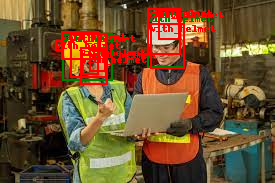

In [40]:
# Make prediction on random image
n = randint(0, dataset_test.len)
img, target = dataset_test[n]
with torch.no_grad():
    prediction = model([img.to(device)])[0]

# Non max suppression to reduce the number of bounding boxes
nms_prediction = apply_nms(prediction, iou_thresh=0.5)
# Remove low score boxes below score_thresh
filtered_prediction = remove_low_score_bb(nms_prediction, score_thresh=0.1)

# Draw bounding boxes
draw_bounding_boxes(img.detach().cpu(), target=target, prediction=filtered_prediction)